# NLP Sentiment Analysis

Group members:

* Khanh Duong TRAN
* Viet Thai NGUYEN
* Minh Duc VU

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Dense, Dropout, Bidirectional, LSTM, Embedding, Flatten

In [2]:
# Plot accuracy and loss
def plot_results(history):
    hist_df = pd.DataFrame(history.history)
    hist_df.columns=["loss", "accuracy", "val_loss", "val_accuracy"]
    hist_df.index = np.arange(1, len(hist_df)+1)

    fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(16, 10))
    axs[0].plot(hist_df.val_accuracy, lw=3, label='Validation Accuracy')
    axs[0].plot(hist_df.accuracy, lw=3, label='Training Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].grid()
    axs[0].legend(loc=0)
    axs[1].plot(hist_df.val_loss, lw=3, label='Validation Loss')
    axs[1].plot(hist_df.loss, lw=3, label='Training Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].grid()
    axs[1].legend(loc=0)

    plt.show()

## Preprocessing

In [3]:
# Read txt files
test_data = pd.read_csv('data/test.txt', delimiter = "\t", names=['sentence'])
train_data = pd.read_csv('data/train.txt', delimiter = "\t", names=['sentence'])

print(train_data.shape, test_data.shape)
print(train_data.head())

(16000, 1) (2000, 1)
                                            sentence
0                    i didnt feel humiliated;sadness
1  i can go from feeling so hopeless to so damned...
2  im grabbing a minute to post i feel greedy wro...
3  i am ever feeling nostalgic about the fireplac...
4                         i am feeling grouchy;anger


In [4]:
# Column for label
train_data['feeling'] = train_data['sentence'].str.split(';').str[1]
test_data['feeling'] = test_data['sentence'].str.split(';').str[1]

# Remove label part in feature
train_data['sentence'] = train_data['sentence'].str.split(';').str[0]
test_data['sentence'] = test_data['sentence'].str.split(';').str[0]

train_data.head()

,sentence,feeling
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [5]:
# Check null values
null_values_train = train_data.isnull().sum()
null_values_test = test_data.isnull().sum()

print("Train data:\n", null_values_train)
print("\nTest data:\n", null_values_test)

Train data:
 sentence    0
feeling     0
dtype: int64

Test data:
 sentence    0
feeling     0
dtype: int64


In [6]:
# Check unique labels
unique_label_train = train_data['feeling'].unique()
unique_label_test = test_data['feeling'].unique()

num_label = len(unique_label_train)

print(sorted(unique_label_train))
print(sorted(unique_label_test))

['anger', 'fear', 'joy', 'love', 'sadness', 'surprise']
['anger', 'fear', 'joy', 'love', 'sadness', 'surprise']


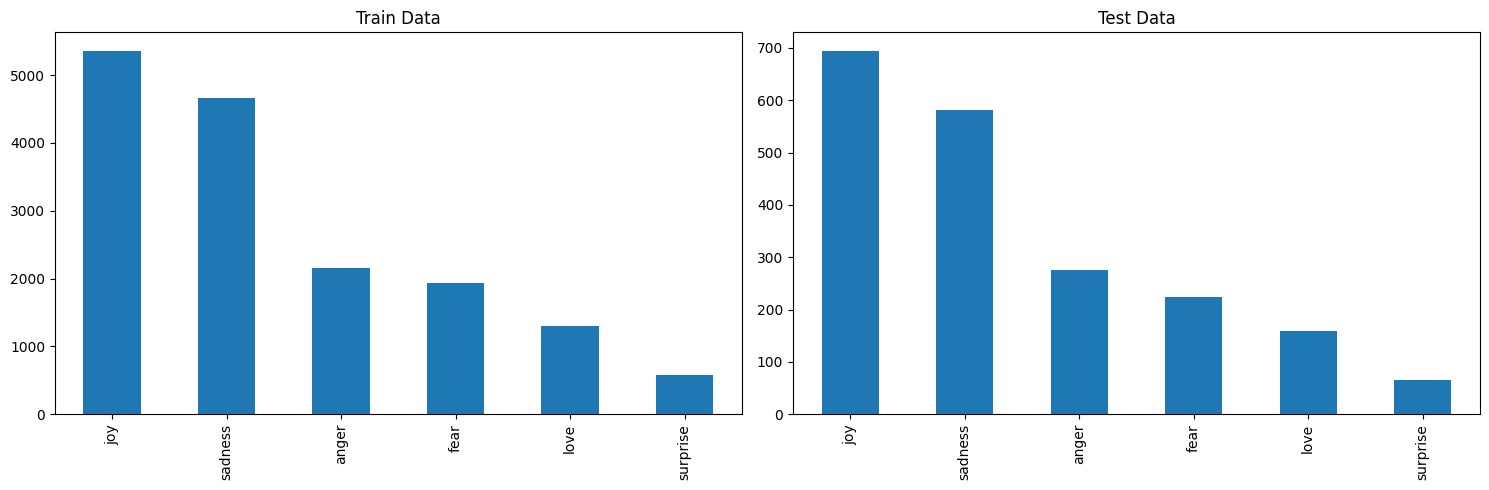

In [7]:
# Plot distribution of labels in train and test data
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

train_data['feeling'].value_counts().plot(kind='bar', ax=axes[0], title='Train Data')
test_data['feeling'].value_counts().plot(kind='bar', ax=axes[1], title='Test Data')

plt.tight_layout()
plt.show()

In [8]:
# Convert to list
train_sentences = train_data['sentence'].tolist()
train_labels = train_data['feeling'].tolist()

test_sentences = test_data['sentence'].tolist()
test_labels = test_data['feeling'].tolist()
  
len(train_sentences), len(test_sentences)


(16000, 2000)

In [9]:
# One-Hot Encode labels
encoder = LabelEncoder()

train_labels_encoded = to_categorical(encoder.fit_transform(train_labels))
test_labels_encoded = to_categorical(encoder.fit_transform(test_labels))

train_labels_encoded

array([[0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.]], dtype=float32)

In [10]:
# Tokenizer
vocab_size = 10000

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(train_sentences)

word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(train_sentences)
test_sequences = tokenizer.texts_to_sequences(test_sentences)

print(len(train_sequences), len(test_sequences))
print(len(word_index))
print(list(word_index.items())[:10])

16000 2000
15213
[('<OOV>', 1), ('i', 2), ('feel', 3), ('and', 4), ('to', 5), ('the', 6), ('a', 7), ('feeling', 8), ('that', 9), ('of', 10)]


In [11]:
# Padding
max_length = 100

train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post')
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post')

print(len(train_padded), len(test_padded))
print(len(train_padded[0]))
print(train_padded[0])

16000 2000
100
[  2 139   3 679   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]


## Fully Connected Neural Network

In [13]:
# Model Definition with Embedding in first layer
embedding_dim = 50

model_nn = tf.keras.Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(num_label, activation='softmax')
])

model_nn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 50)           500000    
                                                                 
 flatten (Flatten)           (None, 5000)              0         
                                                                 
 dense (Dense)               (None, 64)                320064    
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 6)                 198       
                                                                 
Total params: 822342 (3.14 MB)
Trainable params: 822342 (3.14 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [14]:
# Training
num_epochs = 50

history_nn = model_nn.fit(
    train_padded, 
    train_labels_encoded, 
    epochs=num_epochs,
    batch_size=32, 
    validation_data=(test_padded, test_labels_encoded)
)

Epoch 1/50
500/500 [==============================] - 3s 4ms/step - loss: 1.3493 - accuracy: 0.4507 - val_loss: 0.7559 - val_accuracy: 0.7295
Epoch 2/50
500/500 [==============================] - 2s 4ms/step - loss: 0.4609 - accuracy: 0.8436 - val_loss: 0.5182 - val_accuracy: 0.8265
Epoch 3/50
500/500 [==============================] - 2s 4ms/step - loss: 0.1924 - accuracy: 0.9383 - val_loss: 0.5202 - val_accuracy: 0.8405
Epoch 4/50
500/500 [==============================] - 2s 4ms/step - loss: 0.0843 - accuracy: 0.9771 - val_loss: 0.5657 - val_accuracy: 0.8450
Epoch 5/50
500/500 [==============================] - 2s 5ms/step - loss: 0.0435 - accuracy: 0.9892 - val_loss: 0.6243 - val_accuracy: 0.8440
Epoch 6/50
500/500 [==============================] - 2s 5ms/step - loss: 0.0295 - accuracy: 0.9925 - val_loss: 0.6578 - val_accuracy: 0.8335
Epoch 7/50
500/500 [==============================] - 3s 5ms/step - loss: 0.0212 - accuracy: 0.9948 - val_loss: 0.7187 - val_accuracy: 0.8350
Epoch 

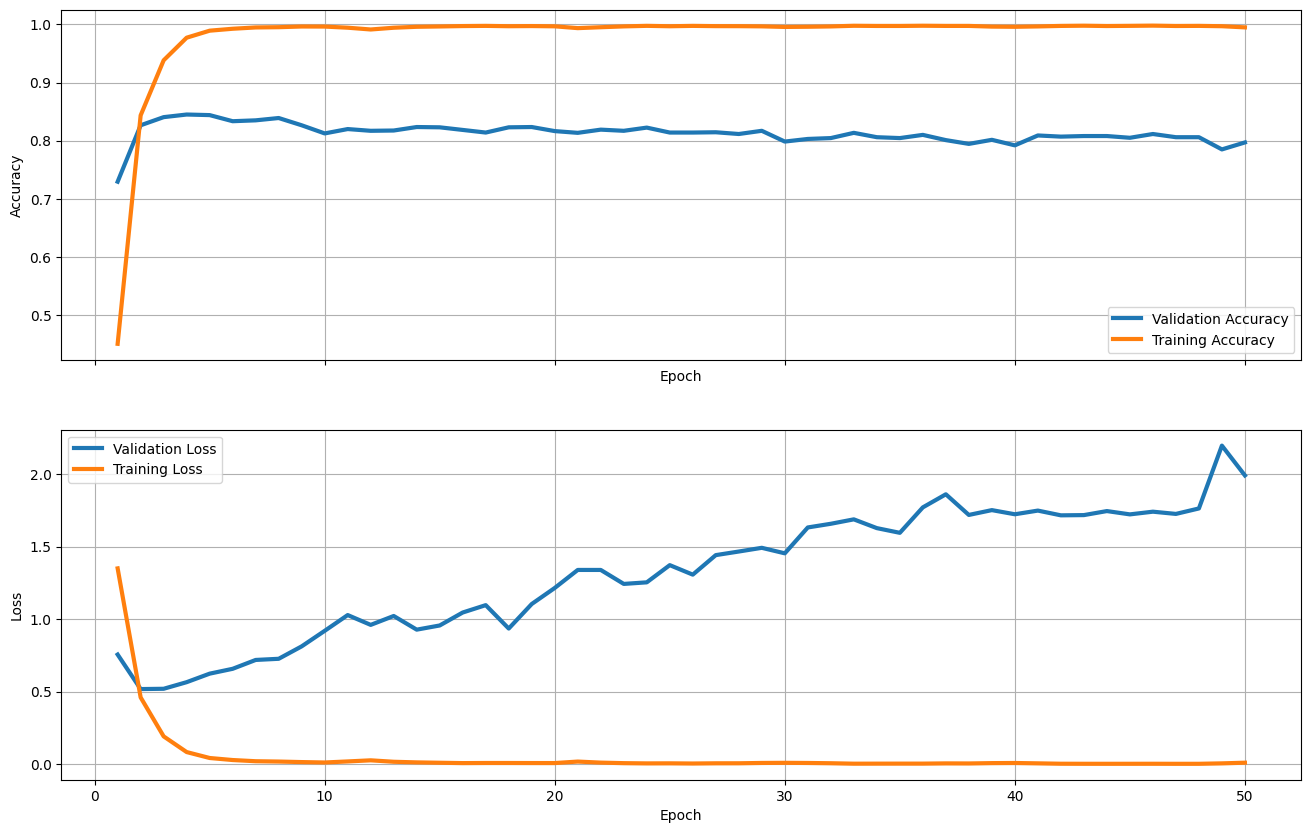

In [15]:
plot_results(history_nn)

In [21]:
# Save the model
model_nn.save('models/nn.h5')

/Users/nguyenvietthai/miniconda3/envs/ml/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Recurent Neural Network (LSTM)

In [18]:
# Model Definition with LSTM and Embedding in the first layer
embedding_dim = 50

model_lstm = tf.keras.Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.2),
    Bidirectional(LSTM(32)),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(num_label, activation='softmax')
])

model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 50)           500000    
                                                                 
 bidirectional_2 (Bidirecti  (None, 100, 128)          58880     
 onal)                                                           
                                                                 
 dropout_2 (Dropout)         (None, 100, 128)          0         
                                                                 
 bidirectional_3 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 16)               

In [19]:
# Training
num_epochs = 50

history_lstm = model_lstm.fit(
    train_padded, 
    train_labels_encoded, 
    epochs=num_epochs, 
    batch_size=32, 
    validation_data=(test_padded, test_labels_encoded)
)

Epoch 1/50
500/500 [==============================] - 35s 62ms/step - loss: 1.2061 - accuracy: 0.5177 - val_loss: 0.7081 - val_accuracy: 0.7235
Epoch 2/50
500/500 [==============================] - 28s 56ms/step - loss: 0.4969 - accuracy: 0.8241 - val_loss: 0.3754 - val_accuracy: 0.8815
Epoch 3/50
500/500 [==============================] - 28s 56ms/step - loss: 0.2576 - accuracy: 0.9164 - val_loss: 0.2722 - val_accuracy: 0.9100
Epoch 4/50
500/500 [==============================] - 28s 57ms/step - loss: 0.1637 - accuracy: 0.9474 - val_loss: 0.2744 - val_accuracy: 0.9125
Epoch 5/50
500/500 [==============================] - 27s 53ms/step - loss: 0.1272 - accuracy: 0.9578 - val_loss: 0.2743 - val_accuracy: 0.9120
Epoch 6/50
500/500 [==============================] - 27s 54ms/step - loss: 0.0982 - accuracy: 0.9672 - val_loss: 0.3253 - val_accuracy: 0.9035
Epoch 7/50
500/500 [==============================] - 27s 55ms/step - loss: 0.0911 - accuracy: 0.9688 - val_loss: 0.2954 - val_accuracy:

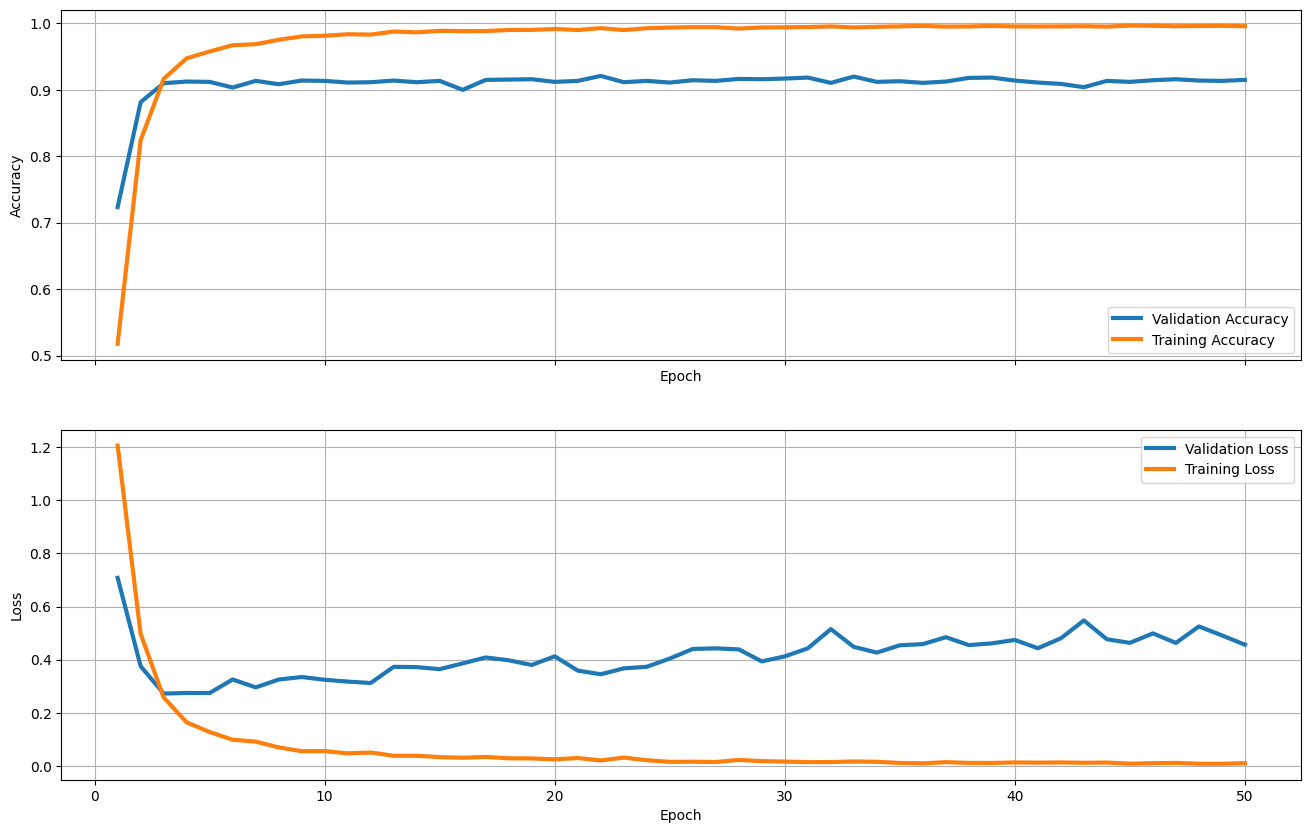

In [20]:
plot_results(history_lstm)

In [22]:
# Save the model
model_lstm.save('models/lstm.h5')